In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import time
from pprint import pprint
import json

In [2]:
#modules for statistics
import math
import statistics
from scipy import stats

# Generate Artists List

In [3]:
# Find a code to get all the artists from this api
#https://www.theaudiodb.com/api_guide.php
# theaudiodb.com/api/v1/json/1/search.php?s=coldplay
artist_names = []

In [4]:
#generate random numbers in the range of available artist IDs
#used to populate artist_names list
random_nums = np.random.randint(low=100000, high=170000, size=800)
#print(ran_ids)

#test with known IDs and intentional erroes
#random_nums = [112024, 0, 100000, 114364]

In [9]:
#create a base url
#example: https://theaudiodb.com/api/v1/json/1/artist.php?i=112024
id_url = "https://theaudiodb.com/api/v1/json/1/artist.php?i="

#create a loop that uses random number
for num in random_nums:
    unique_url = id_url + f'{num}'
    
    #call api url
    request = requests.get(unique_url)
    
    #for each attempt try to convert information to json
    try:
        #convert to json
        info = request.json()
    
    #exception json decode error
    #https://docs.python.org/3/tutorial/controlflow.html
    except json.JSONDecodeError:
        #end this iteration and continue new iteration of for loop
        continue
    
    #if json conversion successful then
    #try to create a variable for single artist to reference later
    try:
        artist = info['artists'][0]['strArtist']
        
    #TypeError exception if url responds with {'artists': None}
    except (TypeError):
        continue
        
    #if the artist is not already in the list then 
    if artist not in artist_names:
        
        #populate artist_names list using info(json)
        #response-> {'artists': [{'idArtist': '114364', 'strArtist': 'Beyoncé', ...
        #dictionary{'artists':['{dictionary}']}
        artist_names.append(info['artists'][0]['strArtist'])
    
    #print(artist_names)

In [10]:
len(artist_names)

723

In [5]:
#print(artist_names)

In [6]:
#alternative to "if not in list then .append"
#convert list to set to remove redundant artists

#unique_artist_ids = set(artist_ids)
#print(unique_artist_ids)

In [7]:
#create loop to pull artist information from the database
#using populated artist_names list
#example url: http://theaudiodb.com/api/v1/json/1/search.php?s=coldplay
#tutorial: https://www.youtube.com/watch?v=pxofwuWTs7c

#create empty dictionary to fill with values
audio_data = {'artist_id':[],
              'artist_name':[],
              'gender':[],
              'members':[],
              'style':[], 
              'genre':[],
             'year_formed':[],
             'year_disbanded':[],
             'location':[]}

#for each artist in the artist list, 
for name in artist_names:
    
    #add the artist name to the base url
    base_url = "http://theaudiodb.com/api/v1/json/1/search.php?s="
    req = requests.get(base_url + f'{name}')
    
    #convert request information into json as a variable
    data = req.json()
    
    #add json values to dictionary
    try:
        audio_data['artist_id'].append(data['artists'][0]['idArtist'])
        audio_data['artist_name'].append(data['artists'][0]['strArtist'])
        audio_data['gender'].append(data['artists'][0]["strGender"])
        audio_data['members'].append(data['artists'][0]["intMembers"])
        audio_data['style'].append(data['artists'][0]["strStyle"])
        audio_data['genre'].append(data['artists'][0]["strGenre"])
        audio_data['year_formed'].append(data['artists'][0]["intFormedYear"])
        audio_data['year_disbanded'].append(data['artists'][0]["strDisbanded"])
        audio_data['location'].append(data['artists'][0]["strCountry"])
    
    #restart loop if TypeError found
    except (TypeError):
        continue

In [13]:
#print(audio_data)

In [14]:
audio_df = pd.DataFrame(audio_data)
audio_df.head(20)

,artist_id,artist_name,gender,members,style,genre,year_formed,year_disbanded,location
0,141637,Regine Dobberschütz,Female,1,,,None,None,Leipzig
1,145266,Bugz in the Attic,Mixed,1,,Funk,None,None,
2,138574,Snix,None,None,None,,1982,None,None
3,121090,Camisa de Vênus,,1,,Rock,1980,None,"Salvador, BR"
4,149388,Claudio Crismani,Male,1,,,None,None,"Trieste, Italy"
5,124998,Andy Fairweather-Low,Male,1,,Rock,1966,None,"Ystrad Mynach, Wales"
6,147709,Subvision,,4,Rock/Pop,Indie Pop,2002,None,"Linköping, Stockholm"
7,115442,Marcy Playground,Male,3,Rock/Pop,Alternative Rock,1997,None,
8,146224,Vanessa Mai,Female,1,,Pop,None,None,"Aspach, Germany"
9,113980,Midnattsol,Mixed,6,Rock/Pop,Metal,2002,None,Germany


In [56]:
# Cleaning the data: replace the 0s, None, and empty strings with null. Year disbanded: replaced None to no, meaning that they haven't disbanded
#To only replace empty values for one column, specify the column name for the DataFrame:
#df["Calories"].fillna(130, inplace = True)

audio_df['year_disbanded'].replace({2021 : 'No'}, inplace = True)
#audio_df_nan = audio_df.replace(0, np.nan)
audio_df['year_formed'].replace({None: 'Null', '0' : np.nan}, inplace = True) 
audio_df['gender'].replace({None: 'Null', '' : 'Null'}, inplace = True) 
audio_df['location'].replace({None: 'Null', '' : 'Null'}, inplace = True)
audio_df['style'].replace({'' : 'Null', None : 'Null'}, inplace = True)
audio_df['genre'].replace({'' : 'Null'}, inplace = True)


#cols = ['year_formed',"gender","BootSize","SuitSize","Type"]
#df2[cols] = df2[cols].replace({'0':np.nan, 0:np.nan})
audio_df.head(20)

,artist_id,artist_name,gender,members,style,genre,year_formed,year_disbanded,location,Code
0,141637,Regine Dobberschütz,Female,1,Null,Null,Null,None,Leipzig,0
1,145266,Bugz in the Attic,Mixed,1,Null,Funk,Null,None,Null,1
2,138574,Snix,Null,None,Null,Null,1982,None,Null,1
3,121090,Camisa de Vênus,Null,1,Null,Rock,1980,None,"Salvador, BR",2
4,149388,Claudio Crismani,Male,1,Null,Null,Null,None,"Trieste, Italy",3
5,124998,Andy Fairweather-Low,Male,1,Null,Rock,1966,None,"Ystrad Mynach, Wales",4
6,147709,Subvision,Null,4,Rock/Pop,Indie Pop,2002,None,"Linköping, Stockholm",5
7,115442,Marcy Playground,Male,3,Rock/Pop,Alternative Rock,1997,None,Null,1
8,146224,Vanessa Mai,Female,1,Null,Pop,Null,None,Germany,6
9,113980,Midnattsol,Mixed,6,Rock/Pop,Metal,2002,None,Germany,7


In [9]:
#replacing and correcting location strings
#replace strings that contain a given value with an entire string
audio_df.loc[audio_df['location'].str.contains('US', na=False), 'location'] = 'USA'
audio_df.loc[audio_df['location'].str.contains('America', na=False), 'location'] = 'USA'
audio_df.loc[audio_df['location'].str.contains('Missour', na=False), 'location'] = 'USA'
audio_df.loc[audio_df['location'].str.contains('Colorado', na=False), 'location'] = 'USA'
audio_df.loc[audio_df['location'].str.contains('California', na=False), 'location'] = 'USA'
audio_df.loc[audio_df['location'].str.contains('Florida', na=False), 'location'] = 'USA'
audio_df.loc[audio_df['location'].str.contains('Indiana', na=False), 'location'] = 'USA'
audio_df.loc[audio_df['location'].str.contains('Texas', na=False), 'location'] = 'USA'
audio_df.loc[audio_df['location'].str.contains('Los Angeles', na=False), 'location'] = 'USA'

audio_df.loc[audio_df['location'].str.contains('UK', na=False), 'location'] = 'UK'
audio_df.loc[audio_df['location'].str.contains('Eng', na=False), 'location'] = 'UK'
audio_df.loc[audio_df['location'].str.contains('Edinburgh', na=False), 'location'] = 'UK'
audio_df.loc[audio_df['location'].str.contains('London', na=False), 'location'] = 'UK'
audio_df.loc[audio_df['location'].str.contains('Scotland', na=False), 'location'] = 'UK'
audio_df.loc[audio_df['location'].str.contains('Ireland', na=False), 'location'] = 'UK'
audio_df.loc[audio_df['location'].str.contains('United Kingdom', na=False), 'location'] = 'UK'
audio_df.loc[audio_df['location'].str.contains('Nottingham', na=False), 'location'] = 'UK'
audio_df.loc[audio_df['location'].str.contains('Croydon', na=False), 'location'] = 'UK'
audio_df.loc[audio_df['location'].str.contains('Liverpool', na=False), 'location'] = 'UK'

audio_df.loc[audio_df['location'].str.contains('German', na=False), 'location'] = 'Germany'
audio_df.loc[audio_df['location'].str.contains('Deutsch', na=False), 'location'] = 'Germany'

audio_df.loc[audio_df['location'].str.contains('Canad', na=False), 'location'] = 'Canada'

audio_df.loc[audio_df['location'].str.contains('Japan', na=False), 'location'] = 'Japan'

audio_df.loc[audio_df['location'].str.contains('French', na=False), 'location'] = 'France'
audio_df.loc[audio_df['location'].str.contains('France', na=False), 'location'] = 'France'
audio_df.loc[audio_df['location'].str.contains('Belgium', na=False), 'location'] = 'Belgium'

audio_df.loc[audio_df['location'].str.contains('Swede', na=False), 'location'] = 'Sweden'
audio_df.loc[audio_df['location'].str.contains('Odense', na=False), 'location'] = 'Denmark'

audio_df.loc[audio_df['location'].str.contains('Switzerland', na=False), 'location'] = 'Switzerland'
audio_df.loc[audio_df['location'].str.contains('Swiss', na=False), 'location'] = 'Switzerland'

audio_df.loc[audio_df['location'].str.contains('Melbourne', na=False), 'location'] = 'Australia'
audio_df.loc[audio_df['location'].str.contains('Australia', na=False), 'location'] = 'Australia'
audio_df.loc[audio_df['location'].str.contains('Zealand', na=False), 'location'] = 'New Zealand'

audio_df.loc[audio_df['location'].str.contains('São Paulo', na=False), 'location'] = 'Brazil'
audio_df.loc[audio_df['location'].str.contains('Brazil', na=False), 'location'] = 'Brazil'

audio_df.loc[audio_df['location'].str.contains('Poznań', na=False), 'location'] = 'Poland'
audio_df.loc[audio_df['location'].str.contains('Portug', na=False), 'location'] = 'Portugal'
audio_df.loc[audio_df['location'].str.contains('Rumania', na=False), 'location'] = 'Romania'
audio_df.loc[audio_df['location'].str.contains('Россия', na=False), 'location'] = 'Russia'
audio_df.loc[audio_df['location'].str.contains('Greece', na=False), 'location'] = 'Greece'

NameError: name 'audio_df' is not defined

In [ ]:
#location stats
#number of times each location appears in the dataframe
location_counts = audio_df['location'].value_counts()

#series
location_counts

In [ ]:

#proportion each location represents in the data
location_proportion = location_counts / location_counts.sum()

#series
location_proportion

In [ ]:
#genre stats
#count of unique genres
genre_counts = audio_df['genre'].value_counts()

#series
genre_counts

In [ ]:
#proportion each genre represents in the data
genre_proportion = genre_counts / genre_counts.sum()

#series
genre_proportion

In [ ]:
#'m working on some code to remove null values 
#from genre and location so we get an accurate proportion
# -- Angela

In [ ]:
# Percentage of artists how are Urban/R&B
#Count of artists per style

Giving location numerical values

In [18]:
audio_df['Code'] = pd.factorize(audio_df.location)[0]
audio_df.head()

,artist_id,artist_name,gender,members,style,genre,year_formed,year_disbanded,location,Code
0,141637,Regine Dobberschütz,Female,1,Null,Null,Null,None,Leipzig,0
1,145266,Bugz in the Attic,Mixed,1,Null,Funk,Null,None,Null,1
2,138574,Snix,Null,None,Null,Null,1982,None,Null,1
3,121090,Camisa de Vênus,Null,1,Null,Rock,1980,None,"Salvador, BR",2
4,149388,Claudio Crismani,Male,1,Null,Null,Null,None,"Trieste, Italy",3


In [20]:
audio_df.Code.value_counts()

1      345
83       7
7        6
25       5
37       4
      ... 
118      1
117      1
116      1
114      1
314      1
Name: Code, Length: 315, dtype: int64

# Gender

In [44]:
statistics.mode(audio_df['gender'])

'Male'

In [48]:
total_artists = len(audio_df['artist_name'].value_counts())
total_artists

714

In [29]:
# percentage of male, female, and mixed artists

gender = audio_df.groupby('gender')
gender_count = gender.nunique()['artist_name']
print(gender_count)

gender_percent = gender_count/total_artists
print(gender_percent)

gender
Female     93
Male      309
Mixed      51
Null      261
Name: artist_name, dtype: int64
gender
Female    0.130252
Male      0.432773
Mixed     0.071429
Null      0.365546
Name: artist_name, dtype: float64


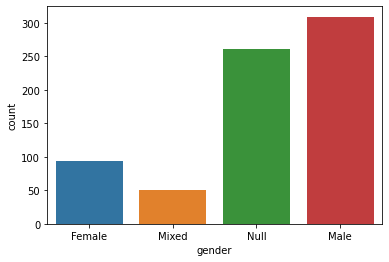

In [38]:
# How many of our artists are male, female, mixed? Create a count plot

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x = 'gender', data = audio_df)
plt.show()

In [39]:
# percentage of male, female, and mixed artists

gender = audio_df.groupby('gender')
gender_count = gender.nunique()['artist_name']
print(gender_count)

gender_percent = gender_count/total_artists
print(gender_percent)


gender
Female     93
Male      309
Mixed      51
Null      261
Name: artist_name, dtype: int64
gender
Female    0.130252
Male      0.432773
Mixed     0.071429
Null      0.365546
Name: artist_name, dtype: float64


In [40]:
audio_df['genre'].value_counts()

Null                   217
Pop                     39
Rock                    24
Hip-Hop                 22
Electronic              18
                      ... 
Post-Punk                1
Stoner Rock              1
Instrumental             1
Turkish Pop              1
Alternative Country      1
Name: genre, Length: 92, dtype: int64

# Location

In [66]:
#location stats
#number of times each location appears in the dataframe
audio_df['location'].value_counts()


Null         345
USA           83
UK            57
Germany       17
Sweden        15
            ... 
Akron          1
Deutch         1
Umeå, SE       1
Delft, NL      1
Cambridge      1
Name: location, Length: 157, dtype: int64

# Artists and Genre

In [63]:
# Artists and genre: Is there a style of music that's more popular for artists?
#statistics.mode(audio_df['genre'])
m_type = audio_df.groupby('style')

music_count =  m_type['artist_name'].count()
print(music_count)

#place = m_type["location"].count()
#print(place)
#sty_location = 


style
Blues                 1
British Rap           1
Classical            20
Clubbing              2
Country               5
East Coast Rap        1
Electronic           46
Folk                 16
Gothic                2
International         3
Jazz                  7
Latin                 3
Manufactured Pop      2
Metal                35
Musicals              1
Null                386
Progressive Rock      1
Punk                 13
Reggae                4
Religious             3
Rock/Pop            133
Russian               1
Urban/R&B            28
Name: artist_name, dtype: int64


In [67]:
# Artist and genre analysis
sty_analysis = {"Artist per Music Style": music_count}
music_analysis = pd.DataFrame(sty_analysis)
music_analysis

,Artist per Music Style
style,
Blues,1
British Rap,1
Classical,20
Clubbing,2
Country,5
East Coast Rap,1
Electronic,46
Folk,16
Gothic,2


In [78]:
# Style and location

# I'm stuck right here

where = audio_df.groupby(['location', 'style'])
most_pop = where['location'].count()
most_pop

location                   style   
\tFlorence, Italy          Null        1
 Budapest                  Metal       1
 Correggio,  Italy         Rock/Pop    1
Aarhus, Danmark            Null        1
Aizkraukle, Latvia         Null        1
                                      ..
Warsaw, Poland             Metal       1
Warwick, GB                Null        1
Winnipeg, Manitoba         Null        1
Wyckoff, New Jersey, U.S.  Rock/Pop    1
Ystrad Mynach, Wales       Null        1
Name: location, Length: 226, dtype: int64

In [46]:
# .value_counts() returns an array containing the # of times each unique value occurs in a given column
# Returns the value counts of each unique value in the purchase_category column

#print(audio_df["style"].value_counts())
statistics.mode(audio_df['style'])

'Null'

In [47]:
total_artists = len(audio_df['artist_name'].value_counts())
total_artists

714

In [50]:
music_type = audio_df.groupby('artist_name')
music_count = gender.nunique()['genre']
print(music_count)

music_percent = music_count/total_artists
print(music_percent)

gender
Female    25
Male      77
Mixed     38
Null      26
Name: genre, dtype: int64
gender
Female    0.035014
Male      0.107843
Mixed     0.053221
Null      0.036415
Name: genre, dtype: float64


In [ ]:
#find the max and min year
#year_bins = [0,9,19,29,39,49]
#year_groups = []

Notes for questions and stats to run:
1. This data is categorical and nominal (unordered)
2. Best to use counts and bar graphs for categorical data
3. Measure of center: Mode - used to categorical data b/c the variables don't have a numerical representation and use the function in stats module: statistics.mode

Questions:

Which artist released the most albums?
Which genre has the most artists?
Is there a relationship between genre and location?

Maybe create a second dataframe with discography api. If so, more questions that could be answered? Year and genre?

- Do groups or individual artist release more albums?
- Which category do the albums fall into?

In [ ]:
# url for: Return Discography for an Artist with Album names and year only
#discography.php?s={Artist_Name}
#Example - theaudiodb.com/api/v1/json/{APIKEY}/discography.php?s=coldplay

base_url = "https://theaudiodb.com/api/v1/json/1/discography.php?s="
artists = "beyonce"

req = requests.get(base_url + f'{artists}')

id_data = req.json()
print(id_data)

{'album': [{'strAlbum': 'Lemonade', 'intYearReleased': '2016'}, {'strAlbum': 'Formation', 'intYearReleased': '2016'}, {'strAlbum': '7/11', 'intYearReleased': '2014'}, {'strAlbum': '711', 'intYearReleased': '2014'}, {'strAlbum': 'Beyoncé', 'intYearReleased': '2013'}, {'strAlbum': 'Life Is but a Dream / Live in Atlantic City', 'intYearReleased': '2013'}, {'strAlbum': '4: The Remix', 'intYearReleased': '2012'}, {'strAlbum': '4 Intimate Nights With Beyoncé', 'intYearReleased': '2011'}, {'strAlbum': '1+1', 'intYearReleased': '2011'}, {'strAlbum': 'Dance For You', 'intYearReleased': '2011'}]}


In [ ]:
id_data['album'][2]['intYearReleased']

'2014'